In [54]:
##LIBRARIES##
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import random
import math
import pickle

#ML
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

#Pytorch
import torch #create tensors to store numeric values
import torch.nn as nn #include weight and bias tensors part of nn
import torch.nn.functional as F #to get activation functions
from torch.optim import SGD #fit network to data using stochastic gradient descent


#Lightning
import lightning as L
from torch import TensorDataset, DataLoader

ImportError: cannot import name 'TensorDataset' from 'torch' (C:\Users\SALDRU1\anaconda3\lib\site-packages\torch\__init__.py)

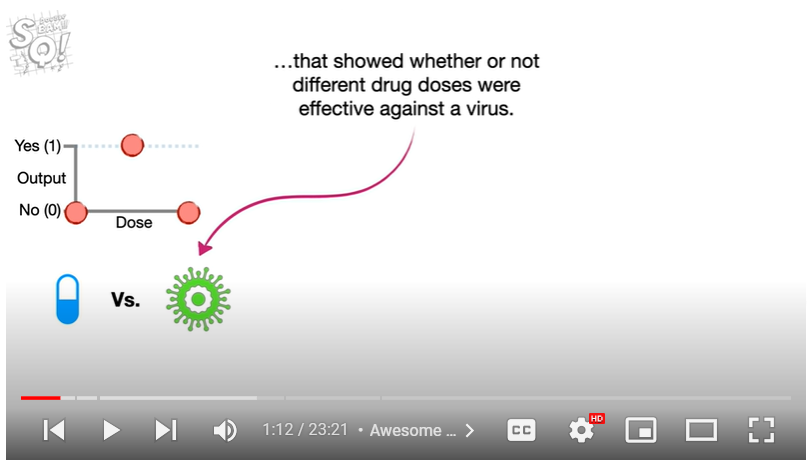

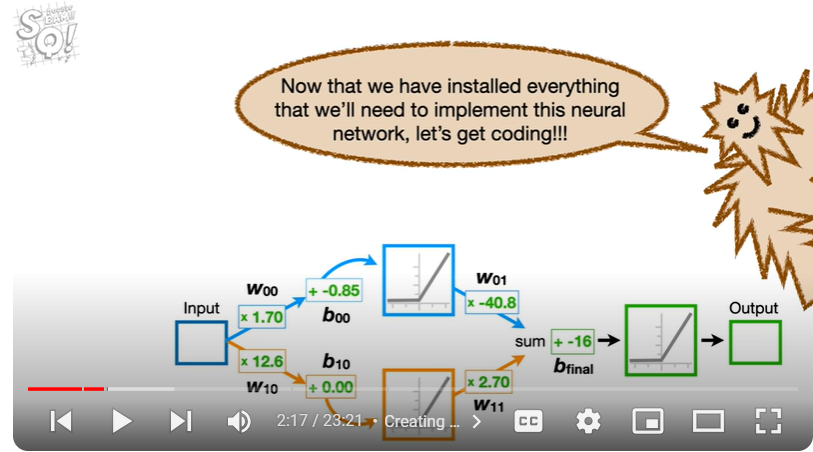

In [44]:

class BasicNN(nn.Module): #create class BasicNN that inherits from pytorch class module
#Alternatively use LightningModule to  
#class BasicLightning(L.LightningModule):  
    #create class to initialise weights and biases
    def __init__(self): #create initialization method for new class
        super().__init__() # call the initialisation method for the parent (super) class nn.module
        #initialise weights and biases in nn
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False) #create new var w00 make it nn parameter so we can optimise it later and set tensor=1.70
        #requires grad = false if not optimising
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)

    def forward(self, input):
        input_to_top_relu = input * self.w00 +self.b00
        top_relu_output = F.relu(input_to_top_relu) #pass input_to_top_relu to ReLU activation function with F.relu
        scaled_top_relu_output = top_relu_output * self.w01 #scale relu output by weight w01    

        input_to_bottom_relu = input * self.w10 +self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu) #pass input_to_top_relu to ReLU activation function with F.relu
        scaled_bottom_relu_output = bottom_relu_output * self.w11 #scale relu output by weight w11  

        #add top and bottom to final bias
        input_to_final_relu = (scaled_top_relu_output
                               + scaled_bottom_relu_output
                               + self.final_bias)

        #then use sum as input to the final Relu to get the output value
        output = F.relu(input_to_final_relu)

        return output

In [45]:
input_doses = torch.linspace(start=0, end=1, steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

Text(0.5, 0, 'Dose')

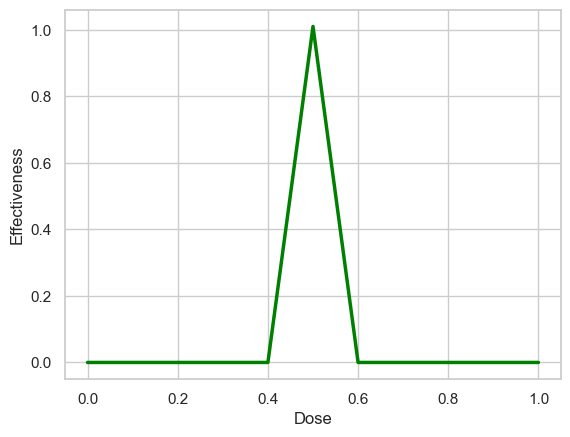

In [46]:
#create neuralnetwork called model that calls class
model = BasicNN()

output_values = model(input_doses) # calls forward method and saves to output_values


#use input and output to draw graph that represents effectiveness of drug doses
sns.set(style="whitegrid")
sns.lineplot(x=input_doses,
            y=output_values,
            color='green',
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")



Graph shows that effectiveness equals 1 when dose is 0.5. Which is correct

#### Optimisation - backprop

In [47]:

class BasicNN_train(nn.Module): #create class BasicNN that inherits from pytorch class module
#Alternatively use LightningModule to  
#class BasicLightning(L.LightningModule):  
    #create class to initialise weights and biases
    def __init__(self): #create initialization method for new class
        super().__init__() # call the initialisation method for the parent (super) class nn.module
        #initialise weights and biases in nn
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)
        #requires grad = true for optimising
        self.final_bias = nn.Parameter(torch.tensor(0.), requires_grad=True) # no longer fits training data

    def forward(self, input):
        input_to_top_relu = input * self.w00 +self.b00
        top_relu_output = F.relu(input_to_top_relu) #pass input_to_top_relu to ReLU activation function with F.relu
        scaled_top_relu_output = top_relu_output * self.w01 #scale relu output by weight w01    

        input_to_bottom_relu = input * self.w10 +self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu) #pass input_to_top_relu to ReLU activation function with F.relu
        scaled_bottom_relu_output = bottom_relu_output * self.w11 #scale relu output by weight w11  

        #add top and bottom to final bias
        input_to_final_relu = (scaled_top_relu_output
                               + scaled_bottom_relu_output
                               + self.final_bias)

        #then use sum as input to the final Relu to get the output value
        output = F.relu(input_to_final_relu)

        return output

Text(0.5, 0, 'Dose')

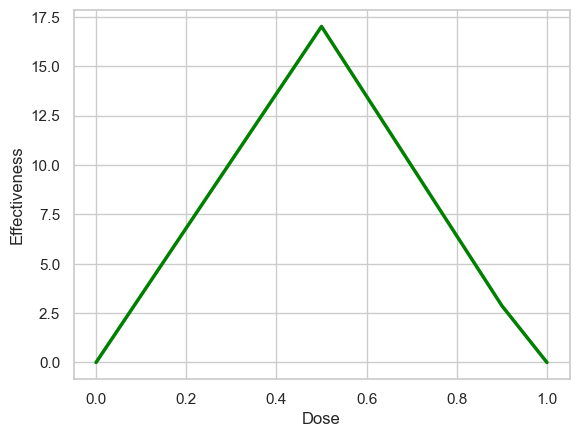

In [48]:
#create neuralnetwork called model that calls class
model = BasicNN_train()

output_values = model(input_doses) # calls forward method and saves to output_values


#use input and output to draw graph that represents effectiveness of drug doses
sns.set(style="whitegrid")
sns.lineplot(x=input_doses,
            y=output_values.detach(), #because final_bias now has gradient, we call detach() on output values to create tensor that only has the values
            color='green',
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")



BassicNN_train model shows that effectiveness equals 17.5 when dose is 0.5. Which is incorrect.

Therefore we need to train nn to optimise b_final.

start by splitting dataset into train and test

In [49]:
#create tensor called inputs with 3 input doses 0, 0.5, 1
inputs = torch.tensor([0., 0.5, 1.])
#create tensor called labels that has observed output values 0,1, 0
labels = torch.tensor([0.,1.,0.])

#now optimise final_bias
#create optimiser object that uses sgd to optimise and set learning rate =0.1
#optimise every parameter that we set requires grad = true
optimizer = SGD(model.parameters(), lr=0.1)

#print optimisation step to see process and gives current tensor value, str function to convert tensor object
print("Final bias, before optimisation: " + str(model.final_bias.data) + "\n")

#an epoch is each time pass training training data through model 
for epoch in range(100):
    
    total_loss = 0 #store loss measure how well fit data, i.e. residual
    
    for iteration in range(len(inputs)):
        
        input_i = inputs[iteration] #dose
        label_i = labels[iteration] #effectiveness
        
        output_i = model(input_i)
        
        loss = (output_i - label_i)**2 #  loss function - rmse for class entropy
        
        # calculate the derivative of the loss function with respect to the parameters want to optimise
        #in this example, that means calculating derivative of squared residual with respect to bfinal and plugging in the predicted and known values
        loss.backward()  #note derivative is additive with each input point - accumulative
        #because everytime we go through loop we create a new function in previous step
        
        #add squared residual to total to keep track of how model is fitting all the data
        total_loss += float(loss)
        
        #do for all data points
        
    if (total_loss < 0.0001): #if total loss is small - break
        print("Num steps: " + str(epoch))
        break
    
    #use derivatives stored in model to step in correct direction
    optimizer.step() # if not small, take a small step toward a better value for optimisation
    optimizer.zero_grad() # zero out derivatives stored in model so that when we enter nexted loop in next epoxh, the new derivatives are not added to old 

    print("Step: " + str(epoch) + "Final Bias:" + str(model.final_bias.data) + "Total loss: " + str(total_loss) + "\n")

print("Final bias, after optimisation: " +str(model.final_bias.data))

Final bias, before optimisation: tensor(0.)

Step: 0Final Bias:tensor(-3.2020)Total loss256.3200988769531

Step: 1Final Bias:tensor(-5.7636)Total loss164.0448760986328

Step: 2Final Bias:tensor(-7.8129)Total loss104.98870849609375

Step: 3Final Bias:tensor(-9.4523)Total loss67.1927719116211

Step: 4Final Bias:tensor(-10.7638)Total loss43.00336837768555

Step: 5Final Bias:tensor(-11.8131)Total loss27.522159576416016

Step: 6Final Bias:tensor(-12.6525)Total loss17.614181518554688

Step: 7Final Bias:tensor(-13.3240)Total loss11.273076057434082

Step: 8Final Bias:tensor(-13.8612)Total loss7.21476936340332

Step: 9Final Bias:tensor(-14.2909)Total loss4.6174516677856445

Step: 10Final Bias:tensor(-14.6348)Total loss2.9551703929901123

Step: 11Final Bias:tensor(-14.9098)Total loss1.8913096189498901

Step: 12Final Bias:tensor(-15.1298)Total loss1.210437297821045

Step: 13Final Bias:tensor(-15.3059)Total loss0.7746805548667908

Step: 14Final Bias:tensor(-15.4467)Total loss0.49579527974128723

S

Weight optimised close to -16, similar to fitted model.

Text(0.5, 0, 'Dose')

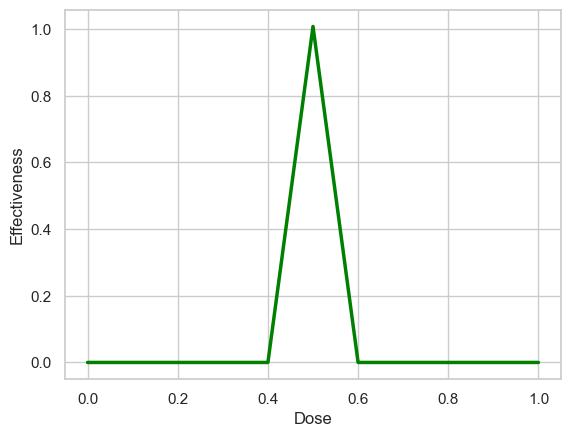

In [51]:
output_values = model(input_doses)

sns.set(style="whitegrid")
sns.lineplot(x=input_doses,
            y=output_values.detach(), 
            color='green',
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")

correct

#### Use Lightning modue

In [56]:

#Alternatively use LightningModule to  
class BasicLightningTrain(L.LightningModule):  
    #create class to initialise weights and biases
    def __init__(self): #create initialization method for new class
        super().__init__() # call the initialisation method for the parent (super) class nn.module
        #initialise weights and biases in nn
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False) #create new var w00 make it nn parameter so we can optimise it later and set tensor=1.70
        #requires grad = false if not optimising
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        
        self.learning_rate = 0.01

    def forward(self, input):
        input_to_top_relu = input * self.w00 +self.b00
        top_relu_output = F.relu(input_to_top_relu) #pass input_to_top_relu to ReLU activation function with F.relu
        scaled_top_relu_output = top_relu_output * self.w01 #scale relu output by weight w01    

        input_to_bottom_relu = input * self.w10 +self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu) #pass input_to_top_relu to ReLU activation function with F.relu
        scaled_bottom_relu_output = bottom_relu_output * self.w11 #scale relu output by weight w11  
        
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)
    
    def

        

In [ ]:
input_doses = torch.linspace(start=0, end=1, steps=11)
input_doses

Text(0.5, 0, 'Dose')

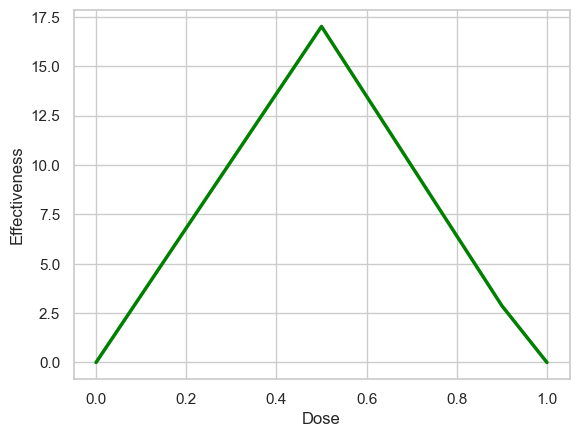

In [57]:
#create neuralnetwork called model that calls class
model = BasicLightningTrain()

output_values = model(input_doses) # calls forward method and saves to output_values


#use input and output to draw graph that represents effectiveness of drug doses
sns.set(style="whitegrid")
sns.lineplot(x=input_doses,
            y=output_values.detach(),
            color='green',
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")



In [ ]:
##Train
#create tensor called inputs with 3 input doses 0, 0.5, 1
inputs = torch.tensor([0., 0.5, 1.])
#create tensor called labels that has observed output values 0,1, 0
labels = torch.tensor([0.,1.,0.])

#Now that we are using Lightning, need to wrap taining data in a dataloader
#So combineinputs and labels into Tensordaaset called dataset
#Then create dataloader called dataloader

datset = TensorDataset(inputs,labels)
dataloader = DataLoader(dataset) 
#dataloader helpful for big data can 
    #1) access data in batches 
    #2) can shuffle data in each epoch
    #3) easy to use small fraction of data if quick and dirty training for debugging
    

#train model to optimise bfinal
